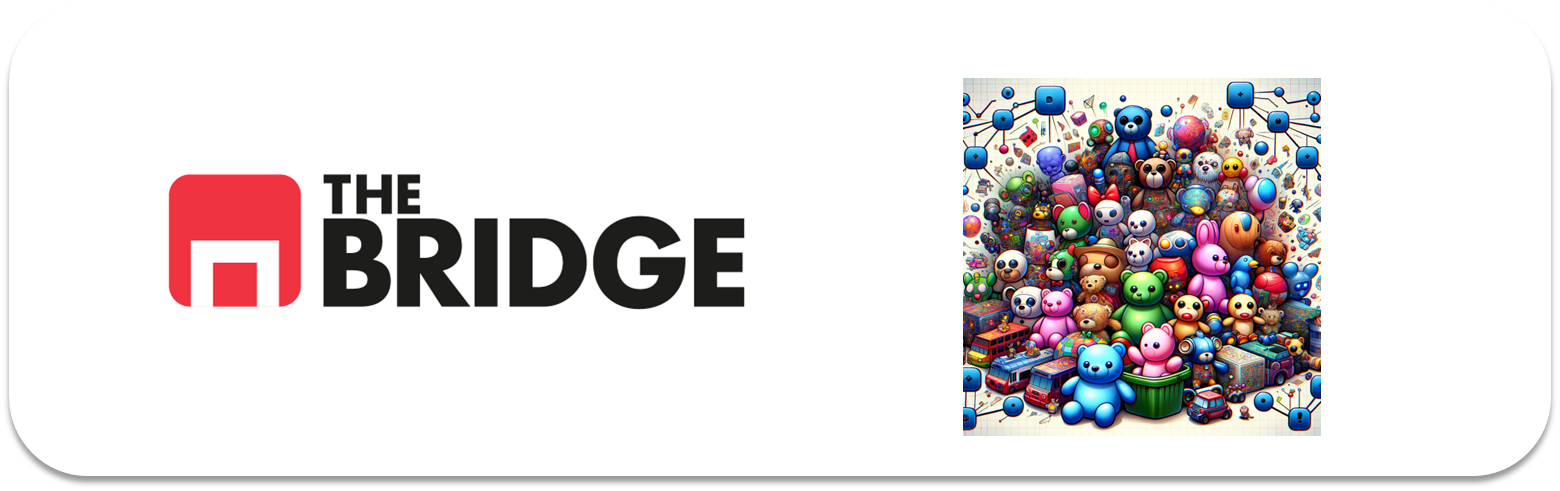

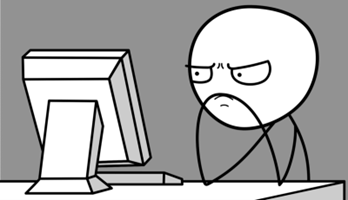

## PRACTICA OBLIGATORIA: DBSCAN y CLUSTERING JERARQUICO

* La práctica obligatoria de esta unidad consiste en un ejercicio de modelado no supervisado aplicado a clustering jerárquico y no jerárquico. Descarga este notebook en tu ordenador y trabaja en local. Ten en cuenta que tendrás que descar los directorios de imágenes y datos adicionales, si los hubiera.
* Recuerda que debes subirla a tu repositorio personal antes de la sesión en vivo para que puntúe adecuadamente.  
* Recuerda también que no es necesario que esté perfecta, sólo es necesario que se vea el esfuerzo. 
* Esta práctica se resolverá en la sesión en vivo correspondiente y la solución se publicará en el repo del curso. 

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.preprocessing import StandardScaler

from bootcampviztools import plot_combined_graphs, bubble_plot, grafico_dispersion_con_correlacion
from sklearn.metrics import silhouette_score

from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score


### Parte I. Modelado

#### Descripción del problema.

En una planta de experimentación con nuevas bebidas energéticas están trabajando con diferentes mezclas de componentes para obtener posibles variedades de su producto estrella "NonstopU". El problema es que la fabricación de cada "prototipo" conlleva demasiado tiempo y las pruebas de sabores y de propiedades "non-stop" antisueño y antifatiga son costosas.  

En ese sentido quieren construir algún sistema de segmentación previa de mezclas sin probarlas solo indicando las cantidades de cada componente de la bebida. Tienen datos pero desgraciadamente de mezclas anteriores con diferentes medidas pero que por temas presupuestarios y de prioridad no se hicieron test con usuarios y potenciales clientes, es decir no tienen un target de capacidad antifatiga o de preferncia del usuario que puedas servirles para construir un clasificador clásico como han hecho otras veces.  

Han acudido a vosotros con la necesida de encontrar ese segmentador de posibles bebidas y con los datos de las mezclas no probadas anteriores por ver si vostros podéis ayudarles a encontrar algún tipo de segmentación que luego ello se encargarían de interpretar. No es requisito obligatorio pero les gustaría también poder establecer algún tipo de relación entre las segmentaciones (tipo cuales segmentos se "parecerían" más entre sí)

NOTA ORIENTATIVA: Los químicos no esperan que haya menos de 3 segmentos ni más de 5.  
NOTA OPERATIVA: El dataset con los datos que nos han dado los químicos está en "./data/empowering_drinks.csv"

**Se pide**: Construir al menos dos algoritmos de clustering (DBSCAN debe ser uno de ellos y el otro debería estar claro cual deberíamos usar dado el enunciado). Compararlos brevemente aunque sea meramente especulativo (¿Por qué es espculativo?)

**Se recomienda**: Visualizar las features dos a dos para escoger las mejores, no necesariamente hay que usar todas, ni tampoco quedarse en dos. Probar diferentes hiperparámetros en función de la nota orientativa y explicar porqué se han escogido los que finalmente se hayan escogido. 

Recuerda que el proceso es similar a lo que vimos en el otro tipo de aprendizaje:
1. Entender el problema
2. Cargar datos, visualizar.
3. MiniEDA: Selección de features
4. Tratamiento de Features.
5. Selección de modelos, selección de hiperparámetros
6. Entrenamiento, visualización de resultados.
7. Discusión de los mismos


In [30]:
df_drinks = pd.read_csv("./data/empowering_drinks.csv", sep="|")
df_drinks.head()

,Azúcares,Vitamínas del grupo B,Cafeína,Ácido Cítrico,Taurina
0,1.518613,0.232053,1.034819,1.013009,0.251717
1,0.246290,-0.827996,0.733629,0.965242,-0.293321
2,0.196879,1.109334,1.215533,1.395148,0.269020
3,1.691550,0.487926,1.466525,2.334574,1.186068
4,0.295700,1.840403,0.663351,-0.037874,-0.319276


In [31]:
df_drinks.info()
df_drinks.describe().T

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 153 entries, 0 to 152
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Azúcares               153 non-null    float64
 1   Vitamínas del grupo B  153 non-null    float64
 2   Cafeína                153 non-null    float64
 3   Ácido Cítrico          153 non-null    float64
 4   Taurina                153 non-null    float64
dtypes: float64(5)
memory usage: 6.1 KB


,count,mean,std,min,25%,50%,75%,max
Azúcares,153.0,0.019231,1.026182,-2.434235,-0.816038,0.061000,0.876275,2.259772
Vitamínas del grupo B,153.0,0.037273,0.995984,-3.679162,-0.499016,-0.023821,0.707247,3.156325
Cafeína,153.0,0.041057,1.040928,-1.695971,-1.043392,0.211566,0.894264,3.062832
Ácido Cítrico,153.0,0.080022,1.009450,-1.493188,-0.738463,-0.165254,0.917474,2.971473
Taurina,153.0,-0.044088,0.934399,-1.634288,-0.799428,-0.154899,0.493956,2.431870


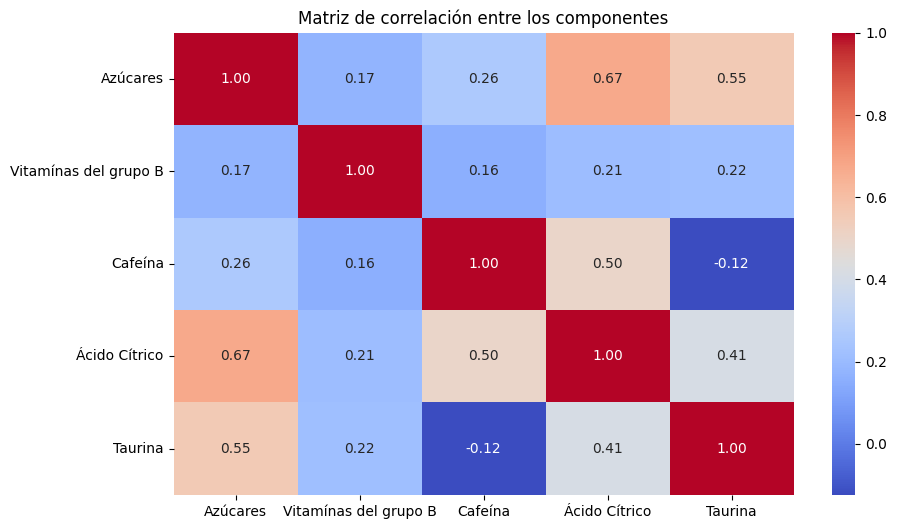

In [32]:
plt.figure(figsize=(10, 6))
sns.heatmap(df_drinks.corr(numeric_only=True), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Matriz de correlación entre los componentes")
plt.show()

In [33]:
df_scaled = df_drinks.copy()


scaler = StandardScaler()

#Aplicamos el escalado (fit + transform)
X_scaled = scaler.fit_transform(df_scaled)

#Convertimos el resultado de nuevo en DataFrame
X_scaled = pd.DataFrame(X_scaled, columns=df_scaled.columns)


X_scaled.head()

,Azúcares,Vitamínas del grupo B,Cafeína,Ácido Cítrico,Taurina
0,1.465925,0.196207,0.957824,0.927289,0.317612
1,0.221992,-0.871612,0.667526,0.879813,-0.267608
2,0.173684,1.079919,1.132002,1.307094,0.336190
3,1.635003,0.453956,1.373917,2.240782,1.320844
4,0.270301,1.816346,0.599790,-0.117176,-0.295475


In [34]:
def plot_dbscan_gridsearch(data, eps_values, min_samples_values):
    """
    Representa el número de clusters y outliers (ruido) en una grid de valores eps y min_samples
    """
    import matplotlib.pyplot as plt
    import seaborn as sns
    from sklearn.cluster import DBSCAN

    fig, axs = plt.subplots(len(min_samples_values), len(eps_values), figsize=(15, 10), sharex=True, sharey=True)

    for i, min_s in enumerate(min_samples_values):
        for j, eps in enumerate(eps_values):
            model = DBSCAN(eps=eps, min_samples=min_s)
            labels = model.fit_predict(data)

            n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
            n_noise = list(labels).count(-1)

            ax = axs[i, j]
            sns.scatterplot(x=data.iloc[:, 0], y=data.iloc[:, 1], hue=labels, ax=ax, legend=False, palette="tab10", s=10)
            ax.set_title(f"eps={eps}, min_samples={min_s}\nclusters={n_clusters}, noise={n_noise}")
            ax.set_xlabel("")
            ax.set_ylabel("")

    plt.tight_layout()
    plt.show()


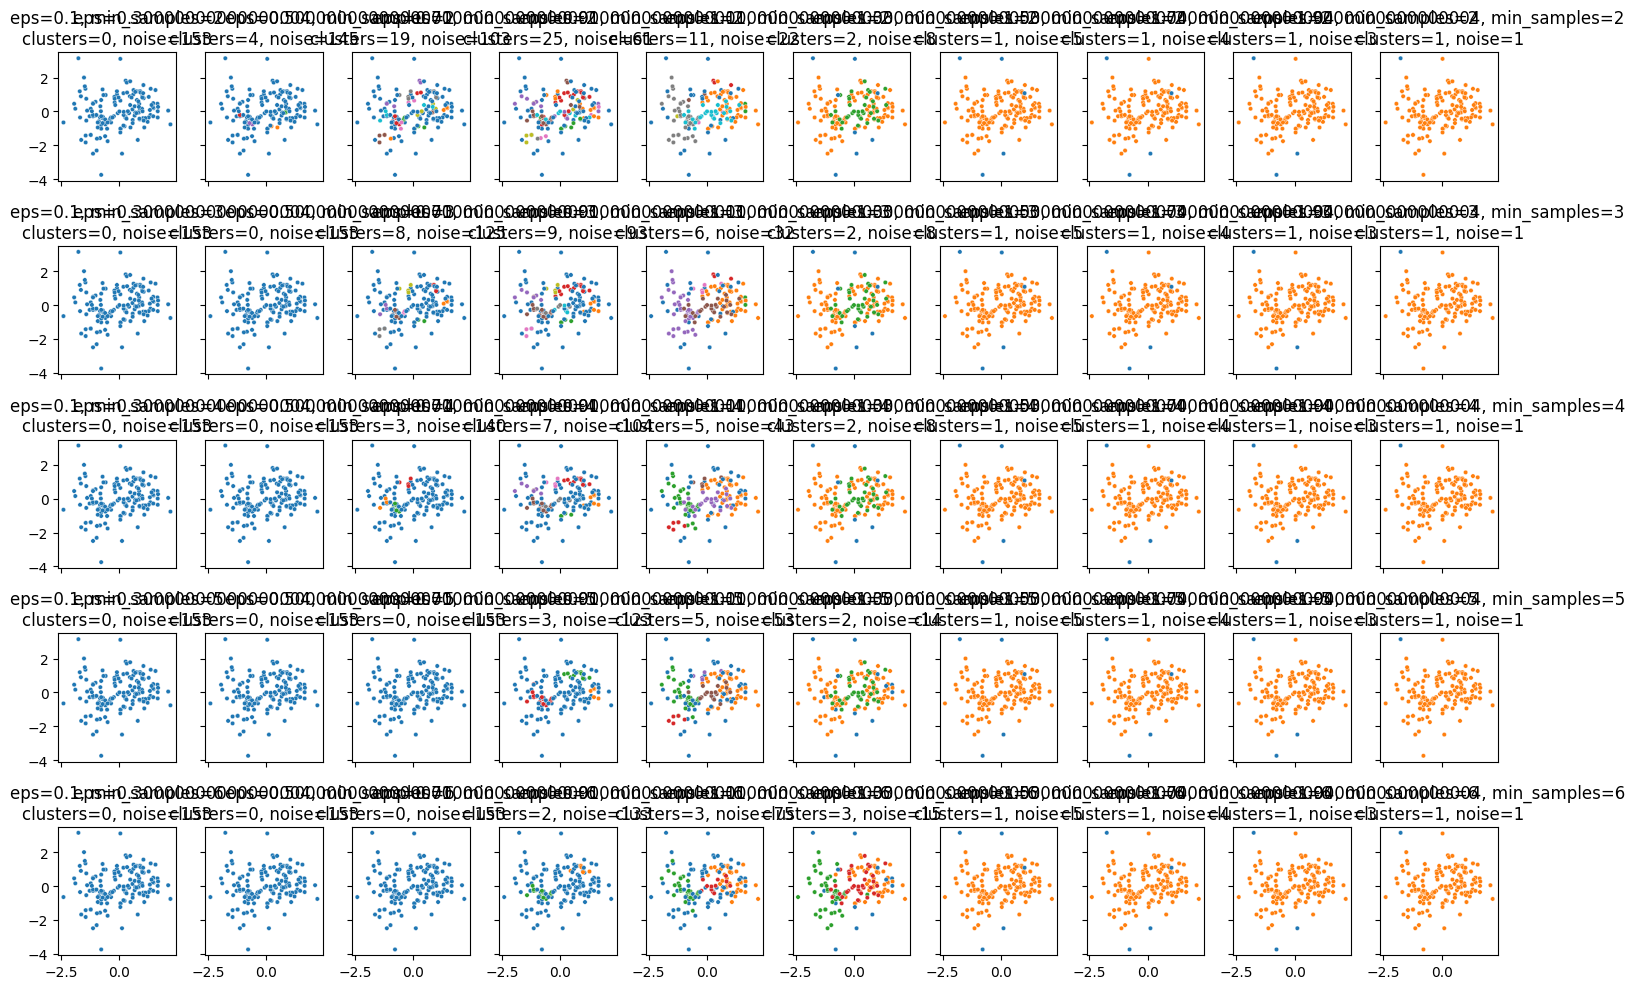

In [35]:
plot_dbscan_gridsearch(X_scaled,
                       eps_values=np.arange(0.1, 2.1, 0.2),
                       min_samples_values=[2, 3, 4, 5, 6])

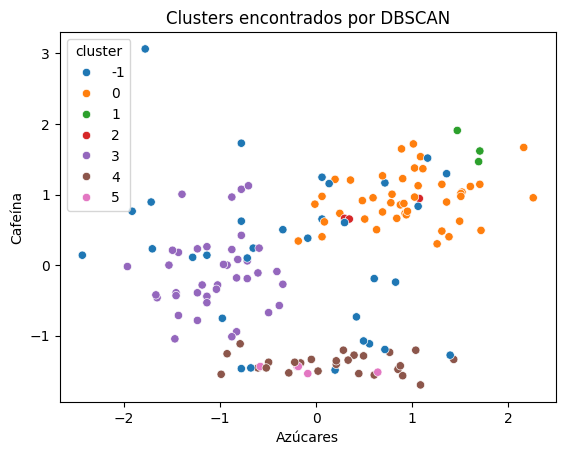

In [36]:
#Entrenamos el modelo DBSCAN con los valores seleccionados
modelo_dbscan = DBSCAN(eps=0.9, min_samples=3)
etiquetas_dbscan = modelo_dbscan.fit_predict(X_scaled)

#Guardamos las etiquetas en un nuevo DataFrame
df_clusters_dbscan = df_drinks.copy()
df_clusters_dbscan["cluster"] = etiquetas_dbscan

#Visualizamos los clusters encontrados
sns.scatterplot(data=df_clusters_dbscan, x="Azúcares", y="Cafeína", hue="cluster", palette="tab10")
plt.title("Clusters encontrados por DBSCAN")
plt.show()


In [37]:
mask = etiquetas_dbscan != -1
sil_score = silhouette_score(X_scaled[mask], etiquetas_dbscan[mask])

print(f"Silhouette Score (sin ruido): {sil_score:.4f}")

Silhouette Score (sin ruido): 0.2764


In [38]:
agg_model = AgglomerativeClustering(n_clusters=6)  
etiquetas_agg = agg_model.fit_predict(X_scaled) 

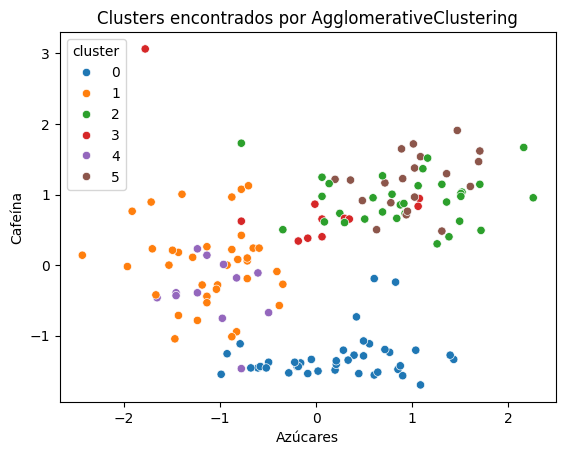

In [39]:
df_clusters_agg = df_drinks.copy()
df_clusters_agg["cluster"] = etiquetas_agg

sns.scatterplot(data=df_clusters_agg, x="Azúcares", y="Cafeína", hue="cluster", palette="tab10")
plt.title("Clusters encontrados por AgglomerativeClustering")
plt.show()

In [40]:
sil_score_agg = silhouette_score(X_scaled, etiquetas_agg)
print(f"Silhouette Score para AgglomerativeClustering: {sil_score_agg:.4f}")

Silhouette Score para AgglomerativeClustering: 0.2674


### Parte II. Nuevos experimentos

Los químicos están muy esperanzados con los modelos que les habéis mostrado y os pasan una lista de nuevos experimentos para que los clasifiquéis. Emplea uno de los modelos construidos, el que te resulte más sencillo, para segmentar los nuevos experimentos que puedes encontrar en "./data/new_experiments.csv"

In [41]:
df_new_experiments = pd.read_csv("./data/new_experiments.csv",sep="|")

print(df_new_experiments.head())
print(df_new_experiments.dtypes)

   Azúcares  Vitamínas del grupo B   Cafeína  Ácido Cítrico   Taurina
0  1.481555               0.305159  1.366128       2.239039  0.731870
1  0.616869               0.890014  0.583034       0.312420 -0.665332
2 -1.680724               0.341713 -0.340615      -0.213021 -0.976782
3 -0.284874              -1.412851 -0.782361      -1.193845 -0.717240
4 -0.927212               0.634140 -1.565455      -0.085641 -0.522583
Azúcares                 float64
Vitamínas del grupo B    float64
Cafeína                  float64
Ácido Cítrico            float64
Taurina                  float64
dtype: object


In [42]:
df_new_experiments = df_new_experiments.apply(pd.to_numeric, errors='coerce')

print(df_new_experiments.head())
print(df_new_experiments.dtypes)


   Azúcares  Vitamínas del grupo B   Cafeína  Ácido Cítrico   Taurina
0  1.481555               0.305159  1.366128       2.239039  0.731870
1  0.616869               0.890014  0.583034       0.312420 -0.665332
2 -1.680724               0.341713 -0.340615      -0.213021 -0.976782
3 -0.284874              -1.412851 -0.782361      -1.193845 -0.717240
4 -0.927212               0.634140 -1.565455      -0.085641 -0.522583
Azúcares                 float64
Vitamínas del grupo B    float64
Cafeína                  float64
Ácido Cítrico            float64
Taurina                  float64
dtype: object


In [43]:
df_new_experiments_numeric = df_new_experiments.dropna()

print(df_new_experiments_numeric.head())

   Azúcares  Vitamínas del grupo B   Cafeína  Ácido Cítrico   Taurina
0  1.481555               0.305159  1.366128       2.239039  0.731870
1  0.616869               0.890014  0.583034       0.312420 -0.665332
2 -1.680724               0.341713 -0.340615      -0.213021 -0.976782
3 -0.284874              -1.412851 -0.782361      -1.193845 -0.717240
4 -0.927212               0.634140 -1.565455      -0.085641 -0.522583


In [44]:
X_new_experiments_scaled = scaler.transform(df_new_experiments_numeric)

#Imprimimos los primeros registros para verificar
print(X_new_experiments_scaled[:5])

[[ 1.42969412  0.26984955  1.27715125  2.14583037  0.83316168]
 [ 0.58430298  0.85899105  0.5223768   0.23097916 -0.66704283]
 [-1.66202206  0.30667089 -0.36786999 -0.29125298 -1.00145374]
 [-0.29731922 -1.46075363 -0.79364019 -1.26608632 -0.72277798]
 [-0.92532407  0.60124165 -1.54841464 -0.16465125 -0.51377116]]


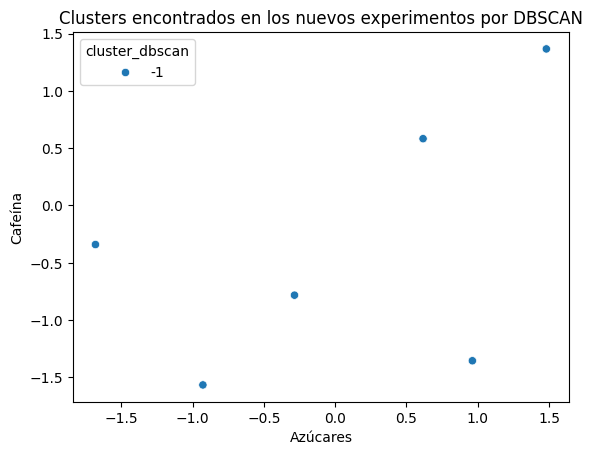

In [49]:
modelo_dbscan.fit(X_new_experiments_scaled)

#Asignamos las etiquetas predichas
etiquetas_dbscan_new = modelo_dbscan.labels_

#Visualizamos los resultados para los nuevos experimentos
df_new_experiments["cluster_dbscan"] = etiquetas_dbscan_new
sns.scatterplot(data=df_new_experiments, x="Azúcares", y="Cafeína", hue="cluster_dbscan", palette="tab10")
plt.title("Clusters encontrados en los nuevos experimentos por DBSCAN")
plt.show()

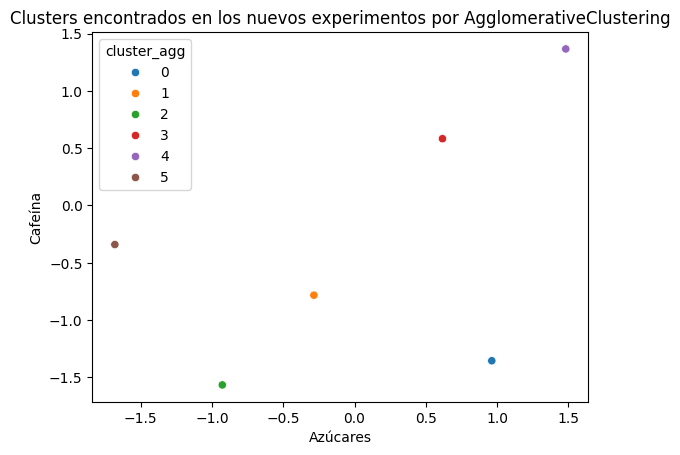

In [50]:
etiquetas_agg_new = agg_model.fit_predict(X_new_experiments_scaled)

#Visualizamos los resultados para los nuevos experimentos
df_new_experiments["cluster_agg"] = etiquetas_agg_new
sns.scatterplot(data=df_new_experiments, x="Azúcares", y="Cafeína", hue="cluster_agg", palette="tab10")
plt.title("Clusters encontrados en los nuevos experimentos por AgglomerativeClustering")
plt.show()

### Parte III. EXTRA (Voluntario): 6 meses después...

La unidad de experimentación recibió un presupuesto adicional gracias a los modelos que les proporcionastes e hizo pruebas con cliente y obtuvo resultados como para clasificar cada bebida en terminos de "energización" en tres niveles (1, media; 2, media-alta, 3, alta). El resultado de los mismos está en el fichero adecuado en el directorio data y alineado con los experimentos iniciales y al final con los nuevos experimentos de la parte anterior.

Evalua la segmentación de los modelos creados en la primera parte.